In [28]:
import scipy as sc
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import shapely.geometry as sg
import datetime
import random

In [65]:
data_sample = pd.read_csv("partition_data.csv", index_col = 0)
data_sample['Order_time'] = pd.to_datetime(data_sample['Order_time'])
# training set split
random.seed(20)
# below are the chosen test dates from our sampling: 20% of 34 days is about 7 days
test_dates = ['09/09/15', '08/13/15', '08/20/15', '09/23/15', '08/24/15', '08/27/15', '08/26/15']
train_dates = list(set(data_sample['date']).difference(test_dates)) 
data_train = data_sample[data_sample.date.isin(train_dates)]
# down sample for kde: this is to improve the density function evaluation (in partitioning)
data_train_sample = data_train[data_train["Order_time"].dt.hour >= 8].sample(frac = 0.1, random_state = 2)

C:\Users\Sheng.Liu\AppData\Local\Temp\ipykernel_3268\1113944385.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(long, lat, 'k.', markersize=2, color = "green")


(-1.9408749949151873,
 2.2707315191277258,
 -2.5461209864525642,
 1.976695051917447)

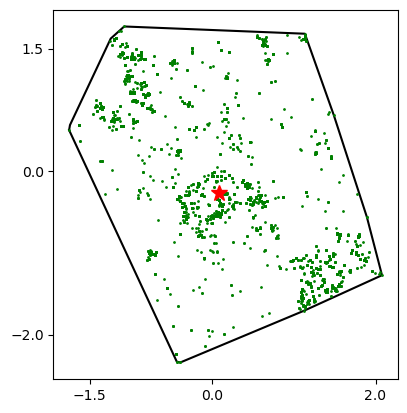

In [71]:
long = data_train['st_long']
lat = data_train['st_lat']
ax = plt.subplot()
plt.plot(*polygon.exterior.xy, color =  'black')
plt.plot(long, lat, 'k.', markersize=2, color = "green")
plt.plot(depot_long, depot_lat, marker = "*", markersize = 12, color = "red")
plt.xticks([-2, -1.5, 0, 2])
plt.yticks([-2, 0, 1.5, 2])
plt.axis('scaled')

# KDE

In [67]:
# estimation
long = data_train_sample['st_long']
lat = data_train_sample['st_lat']
values = np.vstack([long, lat])
kernel = stats.gaussian_kde(values)

([<matplotlib.axis.YTick at 0x1cf95ffc4f0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

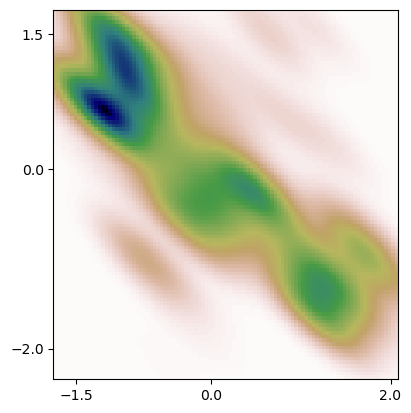

In [72]:
# convex hull using the whole data
points = np.array(list(zip(data_sample['st_long'],data_sample['st_lat'])))
# Find convex hull vertices
hull = ConvexHull(points) 
hull_vertices = tuple(zip(points[hull.vertices,0], points[hull.vertices,1]))
# Build polygon
p = sp.Polygon(*hull_vertices) 
polygon = sg.Polygon(hull_vertices)
depot_lat = (31.229291 - np.mean(raw_lat))/np.std(raw_lat)
depot_long = (121.519489 - np.mean(raw_long))/np.std(raw_long)

# Plot the kde
ax = plt.subplot()
xmin, xmax = min(polygon.exterior.coords.xy[0]), max(polygon.exterior.coords.xy[0])
ymin, ymax = min(polygon.exterior.coords.xy[1]), max(polygon.exterior.coords.xy[1])
XX, YY = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([XX.ravel(), YY.ravel()])
Z = np.reshape(kernel(positions).T, XX.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
plt.xticks([-1.5, 0, 2])
plt.yticks([-2, 0, 1.5])

# Service time

In [69]:
service_time_sample = pd.DataFrame(data_train_sample.groupby(['st_long', 'st_lat'])['service_time'].mean()).reset_index()
X = np.array(service_time_sample[['st_long','st_lat']])
y = np.array(service_time_sample['service_time'])
scorer = make_scorer(mean_squared_error, greater_is_better=False)
parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9],'C': [1, 10, 20, 50, 100, 500]}]
np.random.seed(10)
random.seed(10)
svr = GridSearchCV(SVR(epsilon=0.1), parameters, cv = 5, scoring=scorer)
svr.fit(X, y)
service_time_fct = lambda y,x: float(svr.predict([[x,y]]))

# Approximate travel distance

In [70]:
x_coef, y_coef = 1.1484167246492272, 0.7283785556298928  # estimated from mapping data
distance_fct = lambda x1, y1, x2, y2: x_coef*np.abs(x1-x2)+y_coef*np.abs(y1-y2) # approximation function